# A (Churn Classification)

In [ ]:
!pip install -q xgboost shap scikit-learn pandas matplotlib


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [19:58:36] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


ROC-AUC: 0.8152605114210631
              precision    recall  f1-score   support

           0       0.83      0.87      0.85      1552
           1       0.58      0.51      0.54       561

    accuracy                           0.77      2113
   macro avg       0.71      0.69      0.70      2113
weighted avg       0.77      0.77      0.77      2113



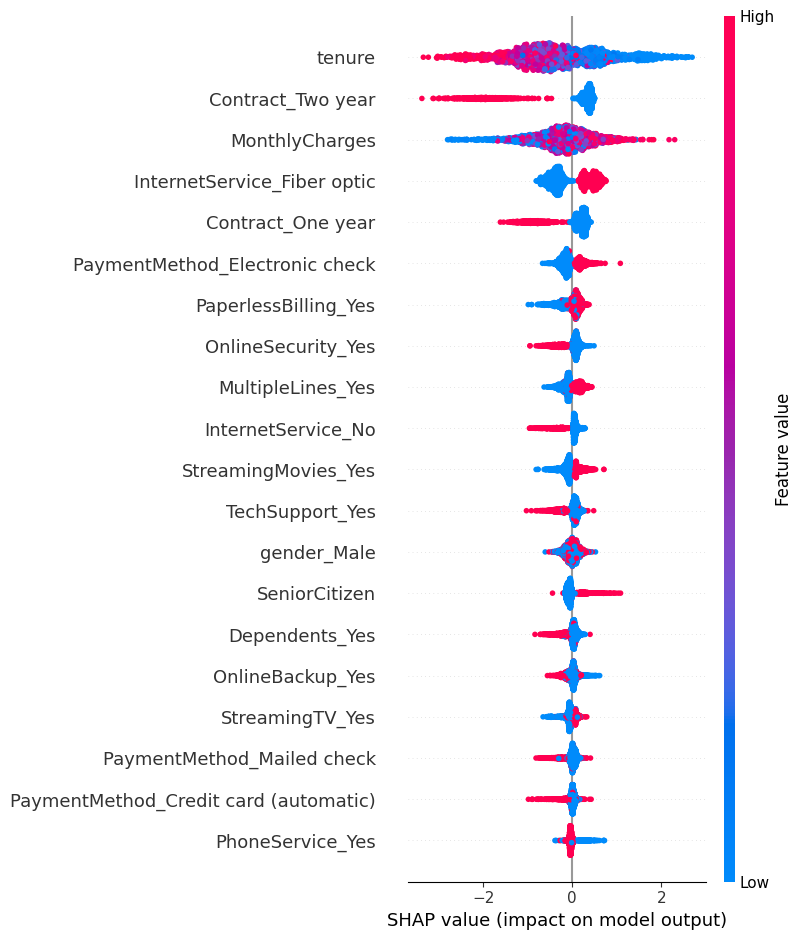

In [ ]:
# A: Churn classification (XGBoost + SHAP) - robust
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report
import xgboost as xgb

df = pd.read_csv("Telco-Customer-Churn.csv")
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})

# one-hot (or you may prefer Ordinal/Target encoding for many cats)
X = pd.get_dummies(df.drop(columns=["Churn"]), drop_first=True)
y = df["Churn"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

model = xgb.XGBClassifier(eval_metric="logloss", use_label_encoder=False, random_state=42)
model.fit(X_train, y_train)

# use probabilities for ROC-AUC
proba = model.predict_proba(X_test)[:,1]
y_pred = model.predict(X_test)
print("ROC-AUC:", roc_auc_score(y_test, proba))
print(classification_report(y_test, y_pred))

# SHAP (try compatible APIs)
try:
    import shap
    # try TreeExplainer first (fast for tree models)
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_test)
    try:
        shap.summary_plot(shap_values, X_test)   # may open plot inline
    except Exception:
        # new API uses Explainer(...) returning an object
        explainer2 = shap.Explainer(model)
        sv = explainer2(X_test)
        shap.summary_plot(sv, X_test)
except Exception as e:
    print("SHAP خطا داد یا نصب نیست:", e)


# B (Survival Analysis)

In [ ]:
!pip install -q lifelines matplotlib


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 7.2 MB/s eta 0:00:00


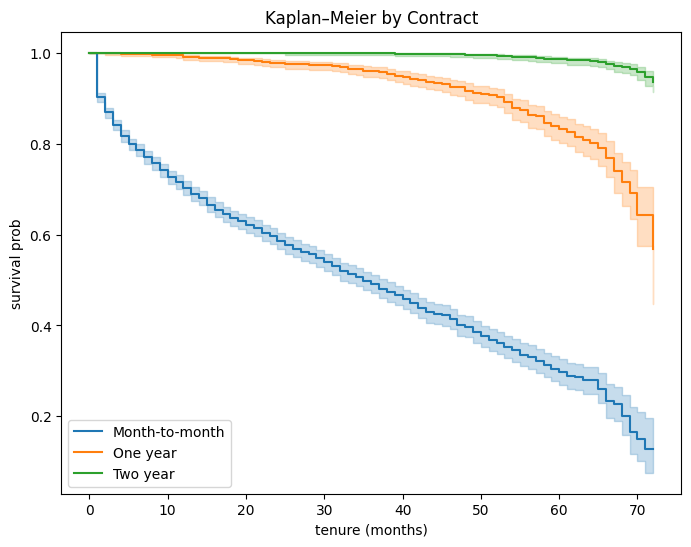

<lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
             duration col = 'tenure'
                event col = 'Churn'
      baseline estimation = breslow
   number of observations = 7043
number of events observed = 1869
   partial log-likelihood = -15586.83
         time fit was run = 2025-08-30 20:09:08 UTC

---
                coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                       
MonthlyCharges  0.00      1.00      0.00            0.00            0.01                1.00                1.01
SeniorCitizen   0.47      1.60      0.05            0.36            0.58                1.44                1.78

                cmp to    z      p  -log2(p)
covariate                                   
MonthlyCharges    0.00 5.92 <0.005     28.19
SeniorCitizen     0.00 8.61 <0.005     56.89
---
Concordance = 0.55
Partial AIC = 31177.67
log-likelihood ratio test = 132.41 on 2 df
-log2(p) of ll-ratio test = 95.52

Concordance: 0.5490010940232881
The ``p_value_threshold`` is set at 0.05. Even under the null hypothesis of no violations, some
covariates will be below the threshold by chance. This is compounded when there are many covariates.
Similarly, when there are lots of observations, even minor deviances from the proportional hazard
assumption will be flagged.

With that in mind, it's best to use a combination of statistical tests and visual tests to determine
the most serious violations. Produce visual plots using ``check_assumptions(..., show_plots=True)``
and looking for non-constant lines. See link [A] below for a full example.



<lifelines.StatisticalResult: proportional_hazard_test>
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 7043 total observations, 5174 right-censored observations>
         test_name = proportional_hazard_test

---
                     test_statistic      p  -log2(p)
MonthlyCharges km             97.71 <0.005     74.12
               rank          105.90 <0.005     80.09
SeniorCitizen  km              4.02   0.04      4.48
               rank            4.60   0.03      4.97



1. Variable 'MonthlyCharges' failed the non-proportional test: p-value is <5e-05.

   Advice 1: the functional form of the variable 'MonthlyCharges' might be incorrect. That is, there
may be non-linear terms missing. The proportional hazard test used is very sensitive to incorrect
functional forms. See documentation in link [D] below on how to specify a functional form.

   Advice 2: try binning the variable 'MonthlyCharges' using pd.cut, and then specify it in
`strata=['MonthlyCharges', ...]` in the call in `.fit`. See documentation in link [B] below.

   Advice 3: try adding an interaction term with your time variable. See documentation in link [C]
below.


2. Variable 'SeniorCitizen' failed the non-proportional test: p-value is 0.0320.

   Advice: with so few unique values (only 2), you can include `strata=['SeniorCitizen', ...]` in
the call in `.fit`. See documentation in link [E] below.

---
[A]  https://lifelines.readthedocs.io/en/latest/jupyter_notebooks/Proportional%20hazard%

In [ ]:
# B: Survival (KM + CoxPH)
import pandas as pd
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter, CoxPHFitter

df = pd.read_csv("Telco-Customer-Churn.csv")
df["Churn"] = df["Churn"].map({"Yes":1, "No":0})
df["tenure"] = pd.to_numeric(df["tenure"], errors="coerce")
df["MonthlyCharges"] = pd.to_numeric(df["MonthlyCharges"], errors="coerce")
df["SeniorCitizen"] = pd.to_numeric(df["SeniorCitizen"], errors="coerce").fillna(0).astype(int)
df = df.dropna(subset=["tenure","Churn","MonthlyCharges","SeniorCitizen"])

# Kaplan-Meier by Contract
kmf = KaplanMeierFitter()
plt.figure(figsize=(8,6))
for c in df["Contract"].unique():
    mask = df["Contract"] == c
    kmf.fit(df.loc[mask, "tenure"], df.loc[mask, "Churn"], label=str(c))
    kmf.plot(ci_show=True)
plt.title("Kaplan–Meier by Contract")
plt.xlabel("tenure (months)")
plt.ylabel("survival prob")
plt.show()

# CoxPH
df_cox = df[["tenure","Churn","MonthlyCharges","SeniorCitizen"]]
cph = CoxPHFitter()
cph.fit(df_cox, duration_col="tenure", event_col="Churn")
cph.print_summary()
print("Concordance:", cph.concordance_index_)

# check assumptions (may print warnings)
try:
    cph.check_assumptions(df_cox, p_value_threshold=0.05, show_plots=False)
except Exception as e:
    print("check_assumptions خطا داد:", e)


# C (Uplift Modeling)

In [ ]:
!pip install -q scikit-uplift scikit-learn pandas


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 755.9 kB/s eta 0:00:00


In [ ]:
# C: Uplift - manual Two-Model (works without sklift)
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv("criteo-uplift .csv")   # یا مسیر خودت
# map offer -> treatment (1 if any real offer, 0 if 'No Offer')
def offer2t(x):
    s = str(x).strip().lower()
    if s in ('no offer','no_offer','none','control',''):
        return 0
    try:
        if float(s)==0.0:
            return 0
    except:
        pass
    return 1
df['treatment'] = df['offer'].apply(offer2t).astype(int)
df['conversion'] = df['conversion'].astype(int)

# features
X = df.drop(columns=['offer','conversion','treatment'])
y = df['conversion'].values
t = df['treatment'].values

cat = X.select_dtypes(include=['object','category']).columns.tolist()
num = X.select_dtypes(exclude=['object','category']).columns.tolist()

try:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
except TypeError:
    ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

pre = ColumnTransformer([('cat', ohe, cat), ('num','passthrough', num)], remainder='drop')
X_train, X_test, y_train, y_test, t_train, t_test = train_test_split(X, y, t, test_size=0.3, random_state=42, stratify=t)

# train separate models
clf_t = Pipeline([('pre', pre), ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])
clf_c = Pipeline([('pre', pre), ('rf', RandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1))])

clf_t.fit(X_train[t_train==1], y_train[t_train==1])
clf_c.fit(X_train[t_train==0], y_train[t_train==0])

p_t = clf_t.predict_proba(X_test)[:,1]
p_c = clf_c.predict_proba(X_test)[:,1]
uplift = p_t - p_c

# simple uplift@30% (manual)
def uplift_at_k_manual(y_true, uplift_scores, treatment, k=0.3):
    n = len(y_true); k_n = max(1,int(n*k))
    idx = np.argsort(uplift_scores)[::-1]
    topk = idx[:k_n]
    # compute diff in response between treated and control inside topk
    if np.sum(treatment[topk]==1)==0 or np.sum(treatment[topk]==0)==0:
        return np.nan
    rr_t = y_true[topk][treatment[topk]==1].mean()
    rr_c = y_true[topk][treatment[topk]==0].mean()
    return rr_t - rr_c

u30 = uplift_at_k_manual(y_test, uplift, t_test, k=0.3)
print("Uplift@30% (manual):", u30)


Uplift@30% (manual): 0.036285173064467546


# D (Sequential Models)

In [1]:
! pip install tensorflow
! pip install pandas
! pip install numpy

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Embedding
from sklearn.model_selection import train_test_split

# تعریف تابع mean_reciprocal_rank
def mean_reciprocal_rank(y_true, y_pred, k=5):
    mrr_scores = []
    for true_val, pred_vals in zip(y_true, y_pred):
        pred_vals = pred_vals[:k]
        if true_val in pred_vals:
            rank = np.where(pred_vals == true_val)[0][0] + 1
            mrr_scores.append(1.0 / rank)
        else:
            mrr_scores.append(0.0)
    return np.mean(mrr_scores)

# بارگذاری و نمونه‌گیری داده‌ها
data = pd.read_csv('events.csv')
data = data.sample(frac=0.1, random_state=42)  # 10٪ نمونه
data = data.sort_values(['visitorid', 'timestamp'])

# آماده‌سازی توالی‌ها
seq_length = 2
sessions = data.groupby('visitorid')['itemid'].apply(list).values
X, y = [], []
for session in sessions:
    for i in range(len(session) - seq_length):
        X.append(session[i:i+seq_length])
        y.append(session[i+seq_length])

X = np.array(X)
y = np.array(y)

# نگاشت آیتم‌ها (فقط 1000 آیتم برتر)
item_counts = data['itemid'].value_counts()
top_items = item_counts.head(1000).index
item_map = {item: idx+1 for idx, item in enumerate(top_items)}
X = np.vectorize(lambda x: item_map.get(x, 0))(X)
y = np.vectorize(lambda x: item_map.get(x, 0))(y)

# تقسیم داده‌ها
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# مدل سبک‌تر
model = Sequential()
model.add(Embedding(input_dim=len(item_map)+1, output_dim=20, input_length=seq_length))
model.add(GRU(50, return_sequences=False))
model.add(Dense(len(item_map)+1, activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')

# آموزش
model.fit(X_train, y_train, epochs=3, batch_size=128, validation_split=0.1)

# پیش‌بینی و ارزیابی
preds = model.predict(X_test)
top_k = np.argsort(-preds, axis=1)[:, :5]  # top 5 پیش‌بینی
mrr = mean_reciprocal_rank(y_test, top_k)
print(f'MRR@5: {mrr:.3f}')

Epoch 1/3


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


21/21 ━━━━━━━━━━━━━━━━━━━━ 9s 92ms/step - loss: 6.8494 - val_loss: 6.4936
Epoch 2/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 6.1192 - val_loss: 4.3618
Epoch 3/3
21/21 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.5638 - val_loss: 2.8405
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step
MRR@5: 0.729
